# CAPSTONE PROJECT 2: A COMPUTER VISION MODEL WHICH DETECTS BONE FRACTURES IN THE UPPER EXTREMITIES NAMELY: WRISTS, FOREARMS, UPPER ARM, & SHOULDER FRACTURES
#### DATA WRANGLING

In [116]:
# import necessary modules for Data Wrangling, namely Pandas, numpy, & motplotlib.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import extra modules as needed here:
import yaml
import os
import torch
from torch import nn
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [117]:
# set up cuda environment
torch.cuda.empty_cache()

BS = 16
LR = 0.00005
epochs = 20
IS = 256
D = 'cuda' if torch.cuda.is_available() else 'cpu'

# set up global variables
num_classes = 7
classes = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l = {k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c = {v:k for k,v in c2l.items()}

# Project Main Directory path
dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2"

# Train Data Paths
train_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train"
train_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train\images"))
train_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\train\labels"))

# Valid Data Paths
val_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid"
val_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid\images"))
val_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\valid\labels"))

# Test Data Paths
test_dir_path = r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test"
test_img_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test\images"))
test_target_paths = sorted(os.listdir(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\test\labels"))

Verify that image data can be accessed and presented.

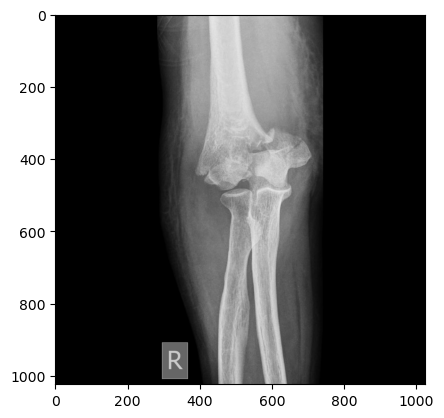

In [118]:
ip=os.path.join(train_dir_path, 'images', train_img_paths[0])
image=cv2.imread(ip)

plt.imshow(image)
plt.show()

In [119]:
# Define Local Classes and functions for this project
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

class FractureData(torch.utils.data.Dataset):
    
    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])
        
        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape
        
        file=open(tp,'r')
        target=list(map(float,file.read().split()))
        
        try:
            label=[target.pop(0)]
            bbox=[]    
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)
        
            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)
            
        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()
        
        annot={'boxes':bbox,'labels':label}
        
        return image, annot
    
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
def extraction(loader, df):
    i=0
    for image, target in loader:
        while i < len(image):
            tar = target[i]
            df.iloc[i,2] = l2c[tar['labels'][0].item()]
            i += 1

Store image and target paths into a data Frame with their respective appendage classification.

In [120]:
df_train = pd.DataFrame({'images': train_img_paths, 'labels': train_target_paths, 'classes': np.NaN, 'class-num': np.NaN})
df_test = pd.DataFrame({'images': test_img_paths, 'labels': test_target_paths, 'classes': np.NaN, 'class-num': np.NaN})
df_val = pd.DataFrame({'images': val_img_paths, 'labels': val_target_paths, 'classes': np.NaN, 'class-num': np.NaN})

In [121]:
df_train.head()

,images,labels,classes,class-num
0,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,NaN,NaN
1,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,NaN,NaN
2,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,NaN,NaN
3,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,NaN,NaN
4,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,NaN,NaN


In [122]:
df_test.head()

,images,labels,classes,class-num
0,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,distal-humerus-fracture-1_jpg.rf.831cb137cfcbd...,NaN,NaN
1,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,image1_0_png.rf.99862308d714bff3f9c410adf5ca93...,NaN,NaN
2,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,image1_1000_png.rf.a53c5e186c03961bf88075c6e3e...,NaN,NaN
3,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,image1_1015_png.rf.3b7320c3c40771fa5532bf713a7...,NaN,NaN
4,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,image1_1015_png.rf.9181f8eb07451331e22381bacb3...,NaN,NaN


In [123]:
df_val.head()

,images,labels,classes,class-num
0,coronoid-process-fracture_jpg.rf.71650459c69a9...,coronoid-process-fracture_jpg.rf.71650459c69a9...,NaN,NaN
1,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,image1_0_png.rf.d29cab92b154a83ca5bf7e40083673...,NaN,NaN
2,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,image1_1000_png.rf.7eebc2918f75be5baf4c32a091e...,NaN,NaN
3,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,image1_1026_png.rf.e9dc3004de762ddd0f75d8f17fb...,NaN,NaN
4,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,image1_1029_png.rf.8f1dfb1982511a9b38867fa9444...,NaN,NaN


In [124]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=BS,collate_fn=trainset.collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


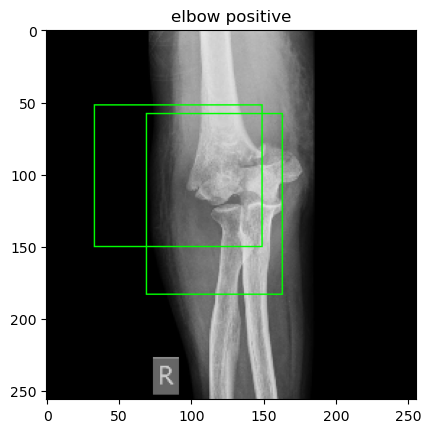

In [125]:
for image,target in trainloader:
    break
img, tar = image[0].permute(1,2,0).numpy(), target[0]

for bbox in tar['boxes']:
    xmin,ymin,xmax,ymax=bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
    sp,ep=(xmin,ymin),(xmax,ymax)
    cv2.rectangle(img,sp,ep,(0,255,0),1)

plt.imshow(img)
plt.title(l2c[tar['labels'][0].item()])
plt.show()


In [126]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=len(train_img_paths),collate_fn=trainset.collate_fn)

testset=FractureData(test_dir_path, test_img_paths, test_target_paths, augs)
testloader=torch.utils.data.DataLoader(testset,batch_size=len(test_img_paths),collate_fn=testset.collate_fn)

valset=FractureData(val_dir_path, val_img_paths, val_target_paths, augs)
valloader=torch.utils.data.DataLoader(valset,batch_size=len(val_img_paths),collate_fn=valset.collate_fn)

In [127]:
extraction(trainloader, df_train)
extraction(testloader, df_test)
extraction(valloader, df_val)

In [128]:
df_train['classes'].value_counts()

fingers positive     898
shoulder fracture    701
elbow positive       647
humerus              515
forearm fracture     496
wrist positive       374
Name: classes, dtype: int64

In [129]:
df_test['classes'].value_counts()

shoulder fracture    58
humerus              36
fingers positive     36
elbow positive       20
forearm fracture     17
wrist positive        2
Name: classes, dtype: int64

In [130]:
df_val['classes'].value_counts()

fingers positive     95
shoulder fracture    66
forearm fracture     62
elbow positive       51
humerus              48
wrist positive       26
Name: classes, dtype: int64

In [131]:
i = 0
while i < len(df_train):
    df_train.iloc[i,3] = c2l[df_train.iloc[i,2]]
    i+=1
    
i = 0
while i < len(df_test):
    df_test.iloc[i,3] = c2l[df_test.iloc[i,2]]
    i+=1
    
i = 0
while i < len(df_val):
    df_val.iloc[i,3] = c2l[df_val.iloc[i,2]]
    i+=1

In [132]:
df_train[df_train['class-num'] == 5].head()

,images,labels,classes,class-num
6,fracture-of-the-humeral-capitellum-milch-type-...,fracture-of-the-humeral-capitellum-milch-type-...,shoulder fracture,5.0
7,fracture-of-the-humeral-capitellum-milch-type-...,fracture-of-the-humeral-capitellum-milch-type-...,shoulder fracture,5.0
8,fracture-of-the-humeral-capitellum-milch-type-...,fracture-of-the-humeral-capitellum-milch-type-...,shoulder fracture,5.0
9,image1_0_png.rf.208b9fc171409973fd0f9af79cdcfe...,image1_0_png.rf.208b9fc171409973fd0f9af79cdcfe...,shoulder fracture,5.0
10,image1_0_png.rf.bc222874fa14e205b638e87ddad52b...,image1_0_png.rf.bc222874fa14e205b638e87ddad52b...,shoulder fracture,5.0


In [133]:
df_test[df_test['class-num'] == 5].head()

,images,labels,classes,class-num
27,image1_145_png.rf.a69d928d011a93d25a95b7b8380e...,image1_145_png.rf.a69d928d011a93d25a95b7b8380e...,shoulder fracture,5.0
28,image1_1471_png.rf.3ba297237985853fdf9e2c9f79f...,image1_1471_png.rf.3ba297237985853fdf9e2c9f79f...,shoulder fracture,5.0
29,image1_148_png.rf.b9799a5fddd2b4b2b747dc5c49f1...,image1_148_png.rf.b9799a5fddd2b4b2b747dc5c49f1...,shoulder fracture,5.0
30,image1_152_png.rf.f6e7109e7499a7a20e4fc8c09406...,image1_152_png.rf.f6e7109e7499a7a20e4fc8c09406...,shoulder fracture,5.0
31,image1_1545_png.rf.cd2ce2cc69004944f0d920c4bda...,image1_1545_png.rf.cd2ce2cc69004944f0d920c4bda...,shoulder fracture,5.0


In [134]:
df_val[df_val['class-num'] == 5].head()

,images,labels,classes,class-num
110,image1_2291_png.rf.62cfeef40c65e7f1fe873335c53...,image1_2291_png.rf.62cfeef40c65e7f1fe873335c53...,shoulder fracture,5.0
111,image1_229_png.rf.ffa8edd3e93e936bd77d678fc83a...,image1_229_png.rf.ffa8edd3e93e936bd77d678fc83a...,shoulder fracture,5.0
112,image1_22_png.rf.06c62da585c7275aade0d95428e27...,image1_22_png.rf.06c62da585c7275aade0d95428e27...,shoulder fracture,5.0
113,image1_230_png.rf.71ef1e82cb7249b449e08e1b0f4b...,image1_230_png.rf.71ef1e82cb7249b449e08e1b0f4b...,shoulder fracture,5.0
114,image1_2327_png.rf.767b817c34c6d8d9a23d3f3914f...,image1_2327_png.rf.767b817c34c6d8d9a23d3f3914f...,shoulder fracture,5.0


In [142]:
df_train['class-num'] = df_train['class-num'].astype(int)
df_test['class-num'] = df_test['class-num'].astype(int)
df_val['class-num'] = df_val['class-num'].astype(int)

In [141]:
df_train['classes'] = df_train['classes'].astype('category')
df_test['classes'] = df_test['classes'].astype('category')
df_val['classes'] = df_val['classes'].astype('category')

In [143]:
df_train.head()

,images,labels,classes,class-num
0,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,distal-humeral-fractures-2-_JPEG.rf.39ba3f5304...,elbow positive,0
1,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,distal-humeral-fractures-2-_JPEG.rf.525ce87678...,elbow positive,0
2,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,distal-humeral-fractures-2-_JPEG.rf.f9442db05e...,elbow positive,0
3,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0
4,elbow-dislocation-with-coronoid-process-fractu...,elbow-dislocation-with-coronoid-process-fractu...,elbow positive,0


This completes my Data cleaning of the dataset.  I borrowed heavily from the project "Fracture Detection - Torch Faster RCNN" found at this link: https://www.kaggle.com/code/sivashankarans/fracture-detection-torch-faster-rcnn/notebook

I originally attempted to create the df_train, df_test, and df_val dataframes from the included YAML file which proved to be a disaster.

The problem with this notebook is it goes straight into the Computer Vision Model without performing any EDA, and since I am immensely looking forward to goin through that process myself I only utilized it for the creation of my dataframes for me to analyze, vizualize, model, and tune to my hearts content.

It was also particularly helpful in providing basic use of PyTorch which I may plausibly use for the modeling phase of this project as well.

I will now save the 3 data sets in my data folder as .csv files for use in my future notebooks.

In [144]:
df_train.to_csv(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_train.csv")
df_test.to_csv(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_test.csv")
df_val.to_csv(r"C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_2\Data\df_val.csv")